In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import zipfile
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

IMG_SIZE =64
NUM_CLASSES=10

NUM_TRAIN_SAMPLES=None
NUM_VAL_SAMPLES =None

BATCH_SIZE =128
EPOCHS =10
LR = 1e-3


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
source_drive_path = '/content/drive/MyDrive/tiny-imagenet.zip'
local_zip_file_path = './tiny-imagenet-dataset/tiny-imagenet.zip'
unzip_destination_path = './tiny-imagenet-dataset/tiny-imagenet'

In [ ]:
os.makedirs(os.path.dirname(local_zip_file_path),exist_ok=True)
shutil.copyfile(source_drive_path,local_zip_file_path)

os.makedirs(unzip_destination_path,exist_ok=True)

#Unzipping
with zipfile.ZipFile(local_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_destination_path)

In [ ]:
DATA_ROOT = './tiny-imagenet-dataset/tiny-imagenet'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VAL_DIR = os.path.join(DATA_ROOT, 'val')

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Normalising to get ==> Zero mean and unit variance
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset =datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset =datasets.ImageFolder(root=VAL_DIR, transform=val_transform)

if NUM_TRAIN_SAMPLES is not None and NUM_TRAIN_SAMPLES<len(train_dataset):
    indices = np.random.choice(len(train_dataset), NUM_TRAIN_SAMPLES, replace=False)
    train_dataset = torch.utils.data.Subset(train_dataset, indices)

if NUM_VAL_SAMPLES is not None and NUM_VAL_SAMPLES < len(val_dataset):
    indices = np.random.choice(len(val_dataset), NUM_VAL_SAMPLES, replace=False)
    val_dataset = torch.utils.data.Subset(val_dataset, indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Number of training batches:{len(train_loader)}")
print(f"Number of validation batches:{len(val_loader)}")

Number of training batches:28
Number of validation batches:4


# **Vanishing Gradients & Modern Fixes**

In [ ]:
class DeepFCN_Sigmoid(nn.Module):
    def __init__(self, input_dim=3*IMG_SIZE*IMG_SIZE, num_classes=NUM_CLASSES):
        super().__init__()
        self.input_dim = input_dim

        self.fc1 =nn.Linear(input_dim, 4096)
        self.fc2 =nn.Linear(4096, 4096)
        self.fc3 =nn.Linear(4096, 2048)
        self.fc4 =nn.Linear(2048, 1024)
        self.fc5 =nn.Linear(1024, 512)
        self.fc6 =nn.Linear(512, 256)
        self.fc7 =nn.Linear(256, 128)
        self.fc8 =nn.Linear(128, 128)
        self.fc9 = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        # Using Xavier initialisation
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    # Setting sigmoid activation fuction
    def forward(self, x):
        x =x.view(x.size(0), -1)
        x =torch.sigmoid(self.fc1(x))
        x =torch.sigmoid(self.fc2(x))
        x =torch.sigmoid(self.fc3(x))
        x =torch.sigmoid(self.fc4(x))
        x =torch.sigmoid(self.fc5(x))
        x =torch.sigmoid(self.fc6(x))
        x =torch.sigmoid(self.fc7(x))
        x=torch.sigmoid(self.fc8(x))
        x =self.fc9(x)
        return x



In [ ]:
class DeepFCN_ReLU_BN(nn.Module):
    def __init__(self, input_dim=3*IMG_SIZE*IMG_SIZE, num_classes=NUM_CLASSES):
        super().__init__()
        self.input_dim =input_dim

        self.fc1 =nn.Linear(input_dim, 4096)
        self.bn1 =nn.BatchNorm1d(4096)
        self.fc2 =nn.Linear(4096, 4096)
        self.bn2 =nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.bn3 =nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 =nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc6 =nn.Linear(512, 256)
        self.bn6 =nn.BatchNorm1d(256)
        self.fc7 = nn.Linear(256, 128)
        self.bn7 =nn.BatchNorm1d(128)
        self.fc8= nn.Linear(128, 128)
        self.bn8 =nn.BatchNorm1d(128)
        self.fc9 =nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        # Using Kaiming initialisation in case of relu actication function.
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    #Using relu activation function
    def forward(self, x):
        x =x.view(x.size(0), -1)
        x =F.relu(self.bn1(self.fc1(x)))
        x =F.relu(self.bn2(self.fc2(x)))
        x =F.relu(self.bn3(self.fc3(x)))
        x =F.relu(self.bn4(self.fc4(x)))
        x =F.relu(self.bn5(self.fc5(x)))
        x =F.relu(self.bn6(self.fc6(x)))
        x =F.relu(self.bn7(self.fc7(x)))
        x=F.relu(self.bn8(self.fc8(x)))
        x =self.fc9(x)
        return x

In [ ]:
def train_one_experiment(model_cls, experiment_name, epochs=EPOCHS):
    model = model_cls().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "first_layer_grad_norm": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        grad_norms = []

        for images, labels in train_loader:
            images =images.to(device, non_blocking=True)
            labels =labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs =model(images)
            loss =criterion(outputs, labels)
            loss.backward()

            # Gradient norm of the first layer weights
            first_layer=model.fc1
            if first_layer.weight.grad is not None:
                grad_norm =first_layer.weight.grad.detach().norm().item()
                grad_norms.append(grad_norm)

            optimizer.step()
            running_loss+=loss.item()*images.size(0)

        epoch_loss=running_loss/len(train_loader.dataset)
        avg_grad_norm =float(np.mean(grad_norms)) if grad_norms else 0.0

        # validation
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images =images.to(device, non_blocking=True)
                labels =labels.to(device, non_blocking=True)
                outputs =model(images)
                loss = criterion(outputs, labels)

                val_running_loss +=loss.item()*images.size(0)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss =val_running_loss/len(val_loader.dataset)
        val_acc = correct / total if total > 0 else 0.0

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["first_layer_grad_norm"].append(avg_grad_norm)

        print(f"[{experiment_name}] Epoch {epoch+1}/{epochs}-"
              f"Train Loss: {epoch_loss:.4f},Val Loss:{val_loss:.4f},"
              f"Val Acc: {val_acc*100:.2f}%, Grad Norm (fc1): {avg_grad_norm:.4e}")

    return history



In [ ]:
history_sigmoid = train_one_experiment(DeepFCN_Sigmoid, "Sigmoid")


[Sigmoid] Epoch 1/10-Train Loss: 2.3346,Val Loss:2.3175,Val Acc: 10.00%, Grad Norm (fc1): 2.2026e-05
[Sigmoid] Epoch 2/10-Train Loss: 2.3119,Val Loss:2.2973,Val Acc: 10.00%, Grad Norm (fc1): 3.8709e-04
[Sigmoid] Epoch 3/10-Train Loss: 2.2180,Val Loss:2.0759,Val Acc: 19.40%, Grad Norm (fc1): 1.6865e-02
[Sigmoid] Epoch 4/10-Train Loss: 2.0272,Val Loss:2.0834,Val Acc: 17.00%, Grad Norm (fc1): 9.3710e-02
[Sigmoid] Epoch 5/10-Train Loss: 1.9985,Val Loss:1.9928,Val Acc: 18.40%, Grad Norm (fc1): 1.5294e-01
[Sigmoid] Epoch 6/10-Train Loss: 2.0600,Val Loss:2.0253,Val Acc: 17.40%, Grad Norm (fc1): 1.4685e-01
[Sigmoid] Epoch 7/10-Train Loss: 1.9620,Val Loss:2.0058,Val Acc: 19.20%, Grad Norm (fc1): 2.1543e-01
[Sigmoid] Epoch 8/10-Train Loss: 2.0049,Val Loss:1.9578,Val Acc: 20.80%, Grad Norm (fc1): 7.9674e-02
[Sigmoid] Epoch 9/10-Train Loss: 1.8918,Val Loss:1.8962,Val Acc: 22.40%, Grad Norm (fc1): 4.0618e-02
[Sigmoid] Epoch 10/10-Train Loss: 1.8308,Val Loss:1.8690,Val Acc: 21.80%, Grad Norm (fc1): 

In [ ]:
history_relu_bn = train_one_experiment(DeepFCN_ReLU_BN, "ReLU+BN")

[ReLU+BN] Epoch 1/10-Train Loss: 1.8987,Val Loss:1.9949,Val Acc: 32.00%, Grad Norm (fc1): 1.7799e+00
[ReLU+BN] Epoch 2/10-Train Loss: 1.6104,Val Loss:1.6818,Val Acc: 36.20%, Grad Norm (fc1): 1.0387e-01
[ReLU+BN] Epoch 3/10-Train Loss: 1.5125,Val Loss:1.6169,Val Acc: 40.40%, Grad Norm (fc1): 1.3158e-01
[ReLU+BN] Epoch 4/10-Train Loss: 1.3888,Val Loss:1.6431,Val Acc: 40.00%, Grad Norm (fc1): 1.5917e-01
[ReLU+BN] Epoch 5/10-Train Loss: 1.3051,Val Loss:1.5927,Val Acc: 40.20%, Grad Norm (fc1): 1.8843e-01
[ReLU+BN] Epoch 6/10-Train Loss: 1.1726,Val Loss:1.6256,Val Acc: 41.00%, Grad Norm (fc1): 2.3700e-01
[ReLU+BN] Epoch 7/10-Train Loss: 1.0717,Val Loss:1.8057,Val Acc: 40.80%, Grad Norm (fc1): 2.7673e-01
[ReLU+BN] Epoch 8/10-Train Loss: 1.0119,Val Loss:1.7532,Val Acc: 42.40%, Grad Norm (fc1): 3.0585e-01
[ReLU+BN] Epoch 9/10-Train Loss: 0.9214,Val Loss:1.9647,Val Acc: 39.40%, Grad Norm (fc1): 3.1860e-01
[ReLU+BN] Epoch 10/10-Train Loss: 0.7903,Val Loss:1.8907,Val Acc: 42.20%, Grad Norm (fc1): 

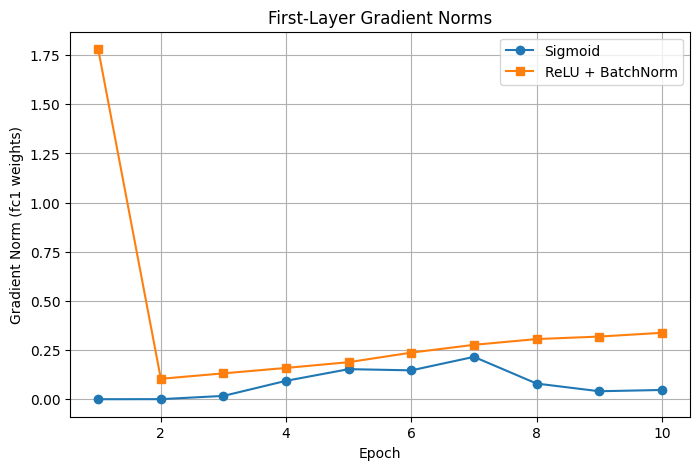

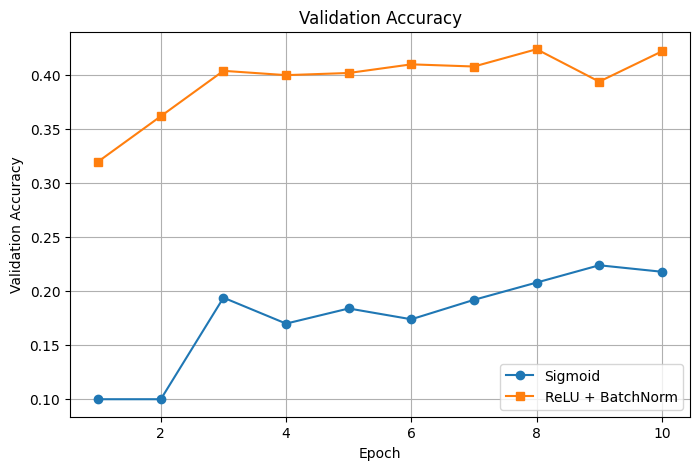

In [ ]:
# Plotting the gradient norms

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range,history_sigmoid["first_layer_grad_norm"], marker="o", label="Sigmoid")
plt.plot(epochs_range, history_relu_bn["first_layer_grad_norm"], marker="s", label="ReLU + BatchNorm")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm (fc1 weights)")
plt.title("First-Layer Gradient Norms")
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation accuracy to see training speed
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history_sigmoid["val_acc"], marker="o", label="Sigmoid")
plt.plot(epochs_range, history_relu_bn["val_acc"], marker="s", label="ReLU + BatchNorm")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation: Which version trains faster and why?

Based on the gradient-norm plot and the validation accuracy curves:

- **Sigmoid network (Experiment A)**: The first-layer gradient norms typically become **very small** as training progresses, especially in such a deep network. Sigmoid activations squish inputs into \((0, 1)\), and their derivatives are at most 0.25 and often close to 0 in the saturated regions. Multiplying many of these small derivatives across 8+ layers leads to **vanishing gradients**, so early layers (like `fc1`) update extremely slowly, and training is slow/unstable.
- **ReLU + BatchNorm network (Experiment B)**: ReLU has derivative 1 in its active region and 0 otherwise, so gradients do **not shrink multiplicatively** in the same way as sigmoids. Batch Normalization further keeps the intermediate activations well-scaled (zero mean, unit variance), which stabilizes gradients and allows for **larger, more consistent gradient norms in the first layer**.

Therefore, **the ReLU + BatchNorm network trains faster**, both because:
1. Gradients do *not* vanish across layers as severely (ReLU), and
2. Internal covariate shift is reduced and activations stay in a good range (BatchNorm), enabling efficient backpropagation even in very deep fully-connected networks.


# **ABLATION STUDY**

Our baseline will be ReLU + Batch Normalisation + Optimizer -- > Adam + LR= 1e-3


In [ ]:
class DeepFCN_ReLU_BN_Dropout(nn.Module):
    #Our baseline NN as we declared above.
    def __init__(self, input_dim=3*IMG_SIZE*IMG_SIZE, num_classes=NUM_CLASSES, dropout_rate=0.5):
        super().__init__()
        self.input_dim = input_dim

        self.fc1 =nn.Linear(input_dim, 4096)
        self.bn1 =nn.BatchNorm1d(4096)
        self.dropout1 =nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 =nn.Linear(4096, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 =nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout4 =nn.Dropout(dropout_rate)
        self.fc5 =nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout5 = nn.Dropout(dropout_rate)
        self.fc6 = nn.Linear(512, 256)
        self.bn6 =nn.BatchNorm1d(256)
        self.dropout6 = nn.Dropout(dropout_rate)
        self.fc7 = nn.Linear(256, 128)
        self.bn7= nn.BatchNorm1d(128)
        self.dropout7 = nn.Dropout(dropout_rate)
        self.fc8 =nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x =x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x =self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x= self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x =self.dropout5(F.relu(self.bn5(self.fc5(x))))
        x = self.dropout6(F.relu(self.bn6(self.fc6(x))))
        x= self.dropout7(F.relu(self.bn7(self.fc7(x))))
        x =self.fc8(x)
        return x


In [ ]:
class DeepFCN_ReLU_BN_NoDropout(nn.Module):
    # Removing Dropout from our baseline model
    def __init__(self, input_dim=3*IMG_SIZE*IMG_SIZE, num_classes=NUM_CLASSES):
        super().__init__()
        self.input_dim = input_dim

        self.fc1 =nn.Linear(input_dim, 4096)
        self.bn1 =nn.BatchNorm1d(4096)
        self.fc2 =nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)
        self.fc3 =nn.Linear(4096, 2048)
        self.bn3= nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 =nn.BatchNorm1d(1024)
        self.fc5= nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc6 =nn.Linear(512, 256)
        self.bn6= nn.BatchNorm1d(256)
        self.fc7 =nn.Linear(256, 128)
        self.bn7= nn.BatchNorm1d(128)
        self.fc8= nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x =x.view(x.size(0), -1)
        x =F.relu(self.bn1(self.fc1(x)))
        x =F.relu(self.bn2(self.fc2(x)))
        x =F.relu(self.bn3(self.fc3(x)))
        x= F.relu(self.bn4(self.fc4(x)))
        x= F.relu(self.bn5(self.fc5(x)))
        x= F.relu(self.bn6(self.fc6(x)))
        x=F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)
        return x

In [ ]:
def train_ablation_experiment(model_cls, experiment_name, optimizer_type="adam", lr=LR, epochs=EPOCHS):
    model = model_cls().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower()=="adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type.lower()=="sgd":
        optimizer =torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    best_val_acc =0.0
    final_val_acc =0.0

    for epoch in range(epochs):
        model.train()
        running_loss=0.0

        for images, labels in train_loader:
            images =images.to(device, non_blocking=True)
            labels=labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs =model(images)
            loss= criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()*images.size(0)

        epoch_loss = running_loss /len(train_loader.dataset)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images =images.to(device, non_blocking=True)
                labels =labels.to(device, non_blocking=True)
                outputs= model(images)
                loss=criterion(outputs, labels)

                val_running_loss+= loss.item()*images.size(0)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss=val_running_loss /len(val_loader.dataset)
        val_acc=correct / total if total > 0 else 0.0
        final_val_acc = val_acc

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if (epoch + 1) % 5 == 0 or epoch==0:
            print(f"[{experiment_name}] Epoch {epoch+1}/{epochs}-"
                  f"Train Loss:{epoch_loss:.4f},Val Loss: {val_loss:.4f},"
                  f"Val Acc:{val_acc*100:.2f}%")

    return final_val_acc, best_val_acc



In [ ]:
print("Running Ablation Study Experiments \n")


# Baseline: ReLU+BN+Dropout, Adam, LR=1e-3
print("\n1. Baseline: ReLU+BN+Dropout, Adam, LR=1e-3")
baseline_final, baseline_best =train_ablation_experiment(
    DeepFCN_ReLU_BN_Dropout, "Baseline (Dropout)", optimizer_type="adam", lr=1e-3
)

# Ablation 1: Remove Dropout
print("\n2. Ablation: Remove Dropout (ReLU+BN only, Adam, LR=1e-3)")
no_dropout_final, no_dropout_best = train_ablation_experiment(
    DeepFCN_ReLU_BN_NoDropout, "No Dropout", optimizer_type="adam", lr=1e-3
)

# Ablation 2: LR too high (10x)
print("\n3. Ablation: LR too high (ReLU+BN+Dropout, Adam, LR=1e-2)")
lr_high_final, lr_high_best = train_ablation_experiment(
    DeepFCN_ReLU_BN_Dropout, "LR=1e-2 (High)", optimizer_type="adam", lr=1e-2
)

# Ablation 3: LR too low (0.1x)
print("\n4. Ablation: LR too low (ReLU+BN+Dropout, Adam, LR=1e-4)")
lr_low_final, lr_low_best = train_ablation_experiment(
    DeepFCN_ReLU_BN_Dropout, "LR=1e-4 (Low)", optimizer_type="adam", lr=1e-4
)

# Ablation 4: Vanilla SGD instead of Adam
print("\n5. Ablation: Vanilla SGD (ReLU+BN+Dropout, SGD, LR=1e-3)")
sgd_final, sgd_best = train_ablation_experiment(
    DeepFCN_ReLU_BN_Dropout, "SGD", optimizer_type="sgd", lr=1e-3
)

Running Ablation Study Experiments 


1. Baseline: ReLU+BN+Dropout, Adam, LR=1e-3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Baseline (Dropout)] Epoch 1/10-Train Loss:2.9358,Val Loss: 2.0969,Val Acc:27.00%
[Baseline (Dropout)] Epoch 5/10-Train Loss:2.0126,Val Loss: 1.6978,Val Acc:31.40%
[Baseline (Dropout)] Epoch 10/10-Train Loss:1.7176,Val Loss: 1.6400,Val Acc:36.40%

2. Ablation: Remove Dropout (ReLU+BN only, Adam, LR=1e-3)
[No Dropout] Epoch 1/10-Train Loss:1.8763,Val Loss: 1.8954,Val Acc:32.00%
[No Dropout] Epoch 5/10-Train Loss:1.2758,Val Loss: 1.6349,Val Acc:42.20%
[No Dropout] Epoch 10/10-Train Loss:0.7335,Val Loss: 1.9428,Val Acc:42.40%

3. Ablation: LR too high (ReLU+BN+Dropout, Adam, LR=1e-2)
[LR=1e-2 (High)] Epoch 1/10-Train Loss:2.4209,Val Loss: 2.5670,Val Acc:24.20%
[LR=1e-2 (High)] Epoch 5/10-Train Loss:1.7617,Val Loss: 1.6875,Val Acc:32.60%
[LR=1e-2 (High)] Epoch 10/10-Train Loss:1.6136,Val Loss: 1.5969,Val Acc:36.00%

4. Ablation: LR too low (ReLU+BN+Dropout, Adam, LR=1e-4)
[LR=1e-4 (Low)] Epoch 1/10-Train Loss:3.0533,Val Loss: 2.2892,Val Acc:12.60%
[LR=1e-4 (Low)] Epoch 5/10-Train Loss:2.72

In [ ]:
results = {
    "Experiment": [
        "Baseline (ReLU+BN+Dropout, Adam, LR=1e-3)",
        "Remove Dropout",
        "LR too high (1e-2)",
        "LR too low (1e-4)",
        "Vanilla SGD (instead of Adam)"
    ],
    "Final Val Accuracy (%)": [
        baseline_final * 100,
        no_dropout_final*100,
        lr_high_final * 100,
        lr_low_final * 100,
        sgd_final * 100
    ],
    "Best Val Accuracy (%)": [
        baseline_best*100,
        no_dropout_best * 100,
        lr_high_best * 100,
        lr_low_best * 100,
        sgd_best * 100
    ],
    "Change from Baseline (%)": [
        0.0,
        (no_dropout_final-baseline_final)*100,
        (lr_high_final-baseline_final) * 100,
        (lr_low_final - baseline_final) *100,
        (sgd_final -baseline_final) *100
    ]
}

df_results = pd.DataFrame(results)
df_results["Final Val Accuracy (%)"] = df_results["Final Val Accuracy (%)"].round(2)
df_results["Best Val Accuracy (%)"] = df_results["Best Val Accuracy (%)"].round(2)
df_results["Change from Baseline (%)"] = df_results["Change from Baseline (%)"].round(2)

print("ABLATION STUDY SUMMARY TABLE")
print(df_results.to_string(index=False))

changes = {
    "Remove Dropout": abs(df_results.loc[1, "Change from Baseline (%)"]),
    "LR too high": abs(df_results.loc[2, "Change from Baseline (%)"]),
    "LR too low": abs(df_results.loc[3, "Change from Baseline (%)"]),
    "Vanilla SGD": abs(df_results.loc[4, "Change from Baseline (%)"])
}

biggest_impact = max(changes, key=changes.get)
print(f"\nBiggest Impact: {biggest_impact} (change: {changes[biggest_impact]:.2f}%)")

ABLATION STUDY SUMMARY TABLE
                               Experiment  Final Val Accuracy (%)  Best Val Accuracy (%)  Change from Baseline (%)
Baseline (ReLU+BN+Dropout, Adam, LR=1e-3)                    36.4                   36.4                       0.0
                           Remove Dropout                    42.4                   43.4                       6.0
                       LR too high (1e-2)                    36.0                   36.2                      -0.4
                        LR too low (1e-4)                    29.6                   29.8                      -6.8
            Vanilla SGD (instead of Adam)                    17.6                   17.6                     -18.8

Biggest Impact: Vanilla SGD (change: 18.80%)


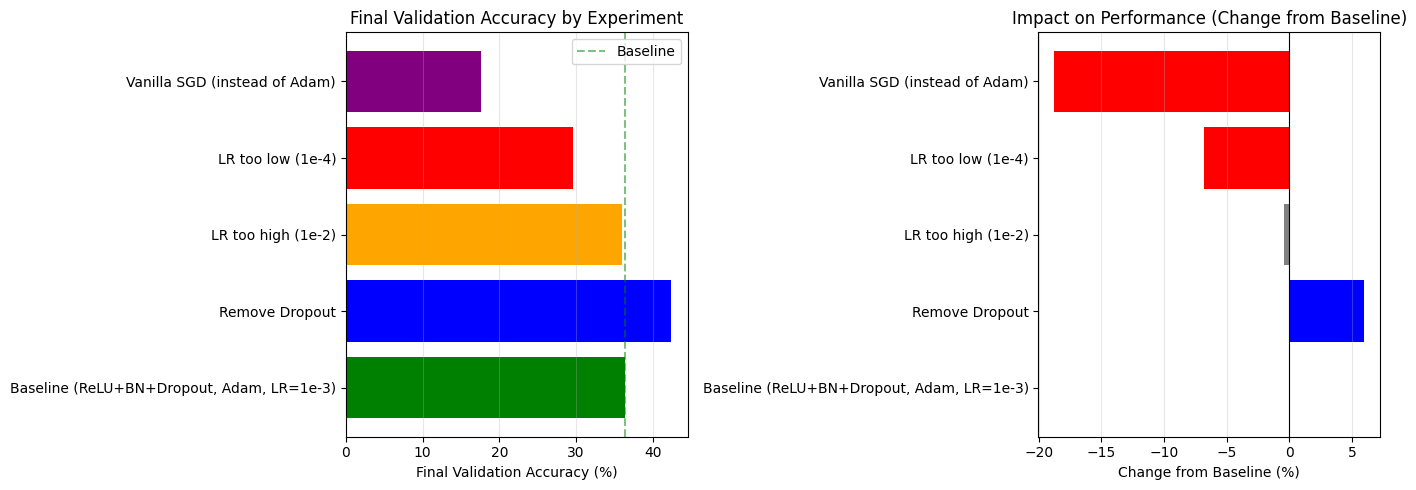

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

experiments = df_results["Experiment"].tolist()
final_accs = df_results["Final Val Accuracy (%)"].tolist()
changes = df_results["Change from Baseline (%)"].tolist()

# Plot 1:Final Validation Accuracy
ax1.barh(experiments, final_accs, color=['green', 'blue', 'orange', 'red', 'purple'])
ax1.set_xlabel("Final Validation Accuracy (%)")
ax1.set_title("Final Validation Accuracy by Experiment")
ax1.axvline(x=baseline_final * 100, color='green', linestyle='--',alpha=0.5, label='Baseline')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2:Change from Baseline
colors_change = ['gray' if abs(c) < 1 else ('red' if c<0 else 'blue') for c in changes]
ax2.barh(experiments, changes, color=colors_change)
ax2.set_xlabel("Change from Baseline (%)")
ax2.set_title("Impact on Performance (Change from Baseline)")
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x',alpha=0.3)

plt.tight_layout()
plt.show()